In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 101 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=a78ee50f37fe4dc267c7af06972fb7eb927c450b63f6c0380980f98bd03703bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9h6tup6/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils import hw12_utils

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.normal import Normal
from torchvision import transforms
import contextlib

from typing import Tuple, Union, List

import copy

from tqdm.notebook import tqdm, trange

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [5]:
class Classifier(nn.Module): 
    def __init__(self, n_classes: int): 
        super().__init__()
        # input_shape = (3, 32, 32)
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), # 3 x 32 x 32 -> 32 x 32 x 32
            nn.BatchNorm2d(32), 
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> 64 x 16 x 16
            nn.BatchNorm2d(64), 
            nn.LeakyReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # -> 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), # -> 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(), 
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.BatchNorm1d(128), 
            nn.LeakyReLU(), 
            nn.Linear(128, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.model(x)

In [ ]:
@contextlib.contextmanager
def disable_tracking_bn_stats(model: nn.Module):
    def switch_attr(m):
        if hasattr(m, "track_running_stats"):
            m.track_running_stats ^= True
       
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)

def normalize(x: torch.Tensor) -> torch.Tensor: 
    x_reshaped = x.view(x.shape[0], -1)
    x_reshaped_norm = F.normalize(x_reshaped, p=2, dim=1)
    x = x_reshaped_norm.view(x.shape)
    return x

In [ ]:
class VAT(nn.Module): 
    def __init__(self, 
                 n_classes: int = 10, 
                 xi: float = 10., 
                 alpha: float = 1.): 
        super().__init__()
        self.classifier = Classifier(n_classes)
        self.xi = xi
        self.alpha = alpha

    def loss_l(self, 
               x: torch.Tensor, 
               y: torch.Tensor) -> torch.Tensor: 
        loss = F.cross_entropy(self.classifier(x), y, reduction="none").mean()
        return loss

    def loss_ul(self, x: torch.Tensor) -> torch.Tensor:  
        with torch.no_grad():
            pred = F.softmax(self.classifier(x), dim=1)

        d = torch.empty(x.shape).normal_(mean=0, std=1).to(device)
        d = normalize(d)

        with disable_tracking_bn_stats(self.classifier):
            r = self.xi * d
            r.requires_grad_()
            pred_hat = self.classifier(x + r)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            adv_distance = F.kl_div(logp_hat, pred, reduction="batchmean")
            adv_distance.backward()
            r_adv = normalize(r.grad)
            self.classifier.zero_grad()
    
            pred_hat = self.classifier(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction="batchmean")
        return lds

    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        labeled = (y != -1)
        loss = self.loss_l(x[labeled], y[labeled]) + self.alpha * self.loss_ul(x)
        return loss

    def test_epoch(self, 
                   test_loader: data.DataLoader) -> float: 
        self.eval()
        total = correct = 0
        with torch.no_grad(): 
            for (x, y) in test_loader: 
                x, y = x.float().to(device), y.to(device)
                pred = self.classifier(x)
                correct += (torch.argmax(pred, dim=1) == y).sum().item()
                total += len(x)
        return correct / total

    def train_model(self, 
                    train_data: data.Dataset, 
                    test_data: data.Dataset, 
                    lr: float = 5e-4, 
                    batch_size: int = 128, 
                    epochs: int = 15) -> Tuple[np.ndarray, np.ndarray]:
        self.train()
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True) 
        test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
        optim = opt.Adam(self.parameters(), lr=lr)

        losses, scores = [], []
        for _ in trange(epochs, desc="Epoch"): 
            scores.append(self.test_epoch(test_loader))
            for (x, y) in train_loader: 
                x, y = x.float().to(device), y.to(device)
                loss = self.loss(x, y)
                losses.append(loss.item())

                optim.zero_grad()
                loss.backward()
                optim.step()

        return np.array(losses), np.array(scores)

In [ ]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1
    test_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """

    model = VAT(10).to(device)
    losses, scores = model.train_model(train_data, test_data, epochs=15)
    return losses, scores

Files already downloaded and verified
Files already downloaded and verified


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

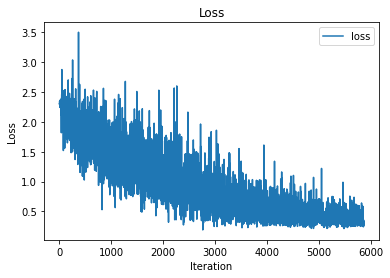

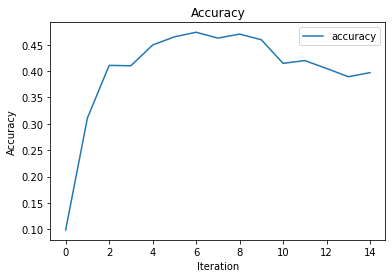

In [ ]:
hw12_utils.q12_results(q1)

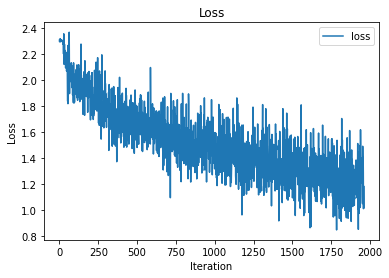

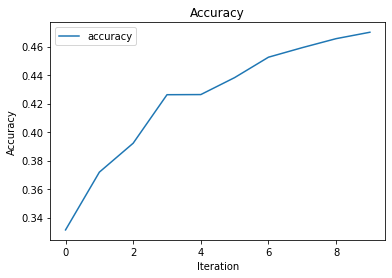

In [ ]:
# Решение Фарида
q_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

In [ ]:
class FixMatch(nn.Module): 
    def __init__(self, n_classes: int): 
        super().__init__()
        self.classifier = Classifier(n_classes)
        self.tau = 0.7
        self.lambda_u = 10
        self.threshold = 0.95
        self.weak_transform = transforms.Compose(
            [
             transforms.RandomHorizontalFlip(), 
             transforms.RandomVerticalFlip()
             ])

        self.strong_transform = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(size=32),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8
                ),
                transforms.RandomGrayscale(0.2),
                transforms.Normalize((0.5,), (0.5,)),
            ])

    def loss_l(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor: 
        x = self.weak_transform(x)
        loss = F.cross_entropy(self.classifier(x), y, reduction="none").mean()
        return loss

    def loss_ul(self, x: torch.Tensor) -> torch.Tensor: 
        with torch.no_grad(): 
            weak_out = self.classifier(self.weak_transform(x))
            pseudo_labels = F.softmax(weak_out / self.tau, dim=1)
            max_probs, targets = torch.max(pseudo_labels, dim=1)
            mask = max_probs >= self.threshold

        n_elements = mask.sum()
        if n_elements == 0: 
            return 0

        strong_out = self.classifier(self.strong_transform(x)) 
        loss = F.cross_entropy(strong_out[mask], targets[mask], reduction="none").sum() / n_elements
        return loss

    def loss(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        labeled = (y != -1)
        loss = self.loss_l(x[labeled], y[labeled]) + self.lambda_u * self.loss_ul(x[~labeled])
        return loss

    def test_epoch(self, 
                   test_loader: data.DataLoader) -> float: 
        self.eval()
        total = correct = 0
        with torch.no_grad(): 
            for (x, y) in test_loader: 
                x, y = x.float().to(device), y.to(device)
                pred = self.classifier(x)
                correct += (torch.argmax(pred, dim=1) == y).sum().item()
                total += x.shape[0]
        return correct / total

    def train_model(self, 
                    train_data: data.Dataset, 
                    test_data: data.Dataset, 
                    lr: float = 5e-4, 
                    batch_size: int = 128, 
                    epochs: int = 20) -> Tuple[np.ndarray, np.ndarray]:
        self.train()
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True) 
        test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
        optim = opt.Adam(self.parameters(), lr=lr)

        losses, scores = [], []
        for _ in trange(epochs, desc="Epoch"): 
            scores.append(self.test_epoch(test_loader))
            for (x, y) in train_loader: 
                x, y = x.float().to(device), y.to(device)
                loss = self.loss(x, y)
                losses.append(loss.item())

                optim.zero_grad()
                loss.backward()
                optim.step()

        return np.array(losses), np.array(scores)

In [ ]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    model = FixMatch(10).to(device)
    losses, scores = model.train_model(train_data, test_data, epochs=20)
    return losses, scores

Files already downloaded and verified
Files already downloaded and verified


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

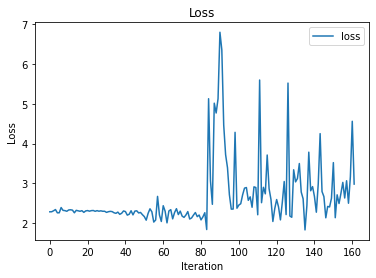

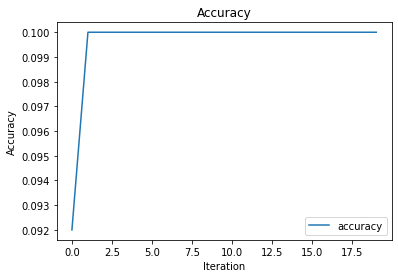

In [17]:
hw12_utils.q12_results(q2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

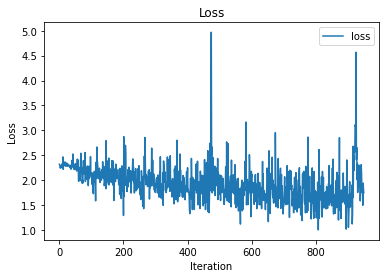

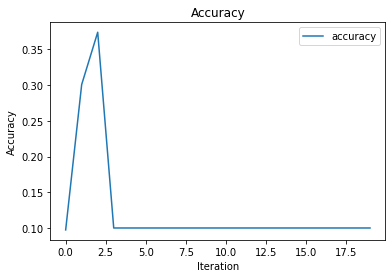

In [8]:
hw12_utils.q12_results(q2)

Files already downloaded and verified
Files already downloaded and verified


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

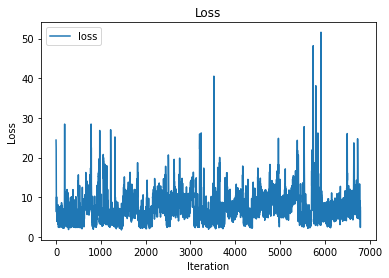

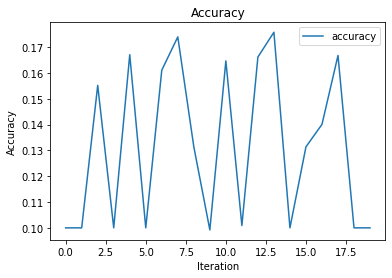

In [ ]:
hw12_utils.q12_results(q2)

Files already downloaded and verified
Files already downloaded and verified


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

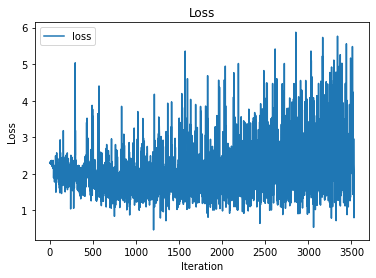

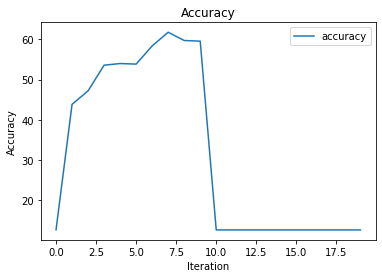

In [ ]:
hw12_utils.q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """